# Mô tả dữ liệu
- Dataset: [Dresses_Attribute_Sales](https://archive.ics.uci.edu/ml/datasets/Dresses_Attribute_Sales)
- Associated Tasks: Classification, Clustering

In [1]:
# import all necessary library
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt

In [2]:
# initialize Spark
spark = SparkSession.builder \
                .master("local") \
                .appName("Data description Spark") \
                .getOrCreate()

In [3]:
# reading dataset to dataframe
schema = StructType([
    StructField("Dress_ID", StringType(), True),
    StructField("Style", StringType(), True),
    StructField("Price", StringType(), True),
    StructField("Rating", FloatType(), True),
    StructField("Size", StringType(), True),
    StructField("Season", StringType(), True),
    StructField("NeckLine", StringType(), True),
    StructField("SleeveLength", StringType(), True),
    StructField("waiseline", StringType(), True),
    StructField("Material", StringType(), True),
    StructField("FabricType", StringType(), True),
    StructField("Decoration", StringType(), True),
    StructField("Pattern Type", StringType(), True),
    StructField("Recommendation", IntegerType(), True)])

df = spark.read \
        .schema(schema) \
        .format("com.databricks.spark.csv") \
        .option("header", "true") \
        .load("Dresses_Attribute_Sales.csv")

df.show(5)

+----------+-------+-------+------+----+------+--------+------------+---------+-------------+----------+----------+------------+--------------+
|  Dress_ID|  Style|  Price|Rating|Size|Season|NeckLine|SleeveLength|waiseline|     Material|FabricType|Decoration|Pattern Type|Recommendation|
+----------+-------+-------+------+----+------+--------+------------+---------+-------------+----------+----------+------------+--------------+
|1006032852|   Sexy|    Low|   4.6|   M|Summer|  o-neck|   sleevless|   empire|         null|   chiffon|   ruffles|      animal|             1|
|1212192089| Casual|    Low|   0.0|   L|Summer|  o-neck|       Petal|  natural|   microfiber|      null|   ruffles|      animal|             0|
|1190380701|vintage|   High|   0.0|   L|Automn|  o-neck|        full|  natural|     polyster|      null|      null|       print|             0|
| 966005983|  Brief|Average|   4.6|   L|Spring|  o-neck|        full|  natural|         silk|   chiffon|embroidary|       print|        

# Các loại dữ liệu
- Nomial
- Numbers
- Odinal
- Ratio

In [4]:
# Nomial
df_nomial = df[["Style", "NeckLine", "Material", "Pattern Type"]]
df_nomial.show(5)

+-------+--------+-------------+------------+
|  Style|NeckLine|     Material|Pattern Type|
+-------+--------+-------------+------------+
|   Sexy|  o-neck|         null|      animal|
| Casual|  o-neck|   microfiber|      animal|
|vintage|  o-neck|     polyster|       print|
|  Brief|  o-neck|         silk|       print|
|   cute|  o-neck|chiffonfabric|         dot|
+-------+--------+-------------+------------+
only showing top 5 rows



In [5]:
# Numbers
df_numbers = df[["Dress_ID"]]
df_numbers.show(5)

+----------+
|  Dress_ID|
+----------+
|1006032852|
|1212192089|
|1190380701|
| 966005983|
| 876339541|
+----------+
only showing top 5 rows



In [6]:
# Ordinal
df_ordinal = df[["Size"]]
df_ordinal.show(5)

+----+
|Size|
+----+
|   M|
|   L|
|   L|
|   L|
|   M|
+----+
only showing top 5 rows



In [7]:
# ratio
df_ratio = df[["Rating"]]
df_ratio.show(5)

+------+
|Rating|
+------+
|   4.6|
|   0.0|
|   0.0|
|   4.6|
|   4.5|
+------+
only showing top 5 rows



# Trung tâm dữ liệu
- Trung bình (mean)
$$\mu = \bar{x} = \frac{1}{n} \sum_{i=1}^n x_i = \frac{1}{n} (x_1 + ... + x_n)$$
- Trung vị (median)
- Mode

In [8]:
df_nomial.describe().show()

+-------+-----+--------+--------+------------+
|summary|Style|NeckLine|Material|Pattern Type|
+-------+-----+--------+--------+------------+
|  count|  500|     499|     499|         499|
|   mean| null|    null|    null|        null|
| stddev| null|    null|    null|        null|
|    min|Brief|    NULL| acrylic|      animal|
|    max| work|  v-neck|    wool|     striped|
+-------+-----+--------+--------+------------+



In [9]:
df_numbers.describe().show()

+-------+--------------------+
|summary|            Dress_ID|
+-------+--------------------+
|  count|                 500|
|   mean|      9.0554168105E8|
| stddev|1.7361896065394258E8|
|    min|          1000425584|
|    max|           999081623|
+-------+--------------------+



In [10]:
df_ordinal.describe().show()

+-------+-----+
|summary| Size|
+-------+-----+
|  count|  500|
|   mean| null|
| stddev| null|
|    min|    L|
|    max|small|
+-------+-----+



In [11]:
df_ratio.describe().show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|               500|
|   mean|3.5285999937057495|
| stddev|  2.00536405618619|
|    min|               0.0|
|    max|               5.0|
+-------+------------------+



In [12]:
mean_rating = df_ratio.agg(F.mean(df_ratio.Rating)).first()[0]
print "Mean rating:", mean_rating

Mean rating: 3.52859999371


In [13]:
sqlContext.registerDataFrameAsTable(df_ratio, "df_ratio")

median_rating = sqlContext.sql("""
    SELECT percentile(Rating, 0.5) AS median_rating 
    FROM df_ratio
""").first()["median_rating"]

print "Median rating:", median_rating

Median rating: 4.59999990463


In [14]:
counts = df_ratio.groupBy("Rating").count()

mode_rating = counts.join(
        counts.agg(F.max('count').alias('count')),
        on='count'
    ).limit(1).select("Rating").first()["Rating"]

print "Mode rating:", mode_rating

Mode rating: 0.0


/Users/hongong/virtualenv/trustingsocial/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


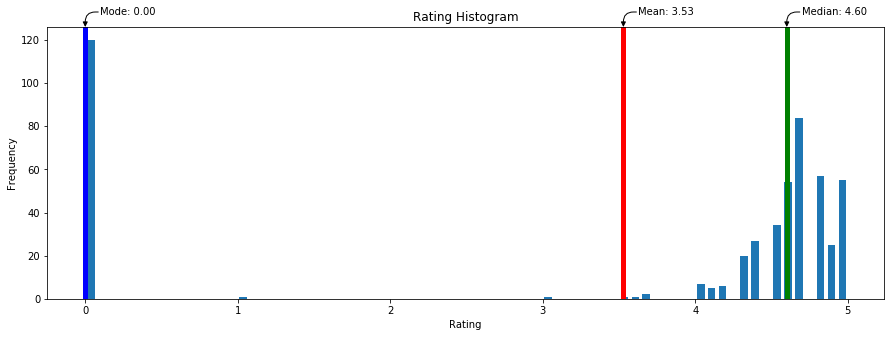

In [15]:
# visualize price column
fig, ax = plt.subplots(figsize=(15, 5))
ax.axvline(mean_rating, color='red', linewidth=5)
ax.axvline(median_rating, color='green', linewidth=5)
ax.axvline(mode_rating, color='blue', linewidth=5)

# Add arrows annotating the means:
def add_arrow(label, val, align="left"):
    ax.annotate(label + ': {:0.2f}'.format(val), xy=(val, 1), xytext=(15, 15),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment=align, verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

add_arrow("Mean", mean_rating)
add_arrow("Median", median_rating)
add_arrow("Mode", mode_rating)
ax.legend(loc='upper left')
ax.margins(0.05)

bins, hist = df_ratio.select("Rating").rdd.flatMap(lambda x: x).histogram(70)
hist = np.asarray(hist)
bins = np.asarray(bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("Rating Histogram")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Biến đổi của dữ liệu 
- Khoảng đoạn (range)
$$range = maxValue - minValue$$

- Phương sai (variance)
$$\sigma^2 = \frac{\sum_{i=1}^n (x_i - \mu)}{n}$$

- Độ lệch chuẩn (standard deviation)
$$\sigma = \sqrt{\frac{\sum_{i=1}^n (x_i - \mu)}{n}}$$

- Z-score: biến đổi từ sample mean để thực hiện Z-test
    * Shift trung bình mẫu về 0 bằng $X - \mu$
    * Nén độ lệch chuẩn của mẫu ban đầu lại bằng cách chia cho $\sigma$
$$Z = \frac{X - \mu}{\sigma}$$

- Phân vị (percentile)
$$percentile \ of \ x = \frac{No. value \ below \ x}{n} * 100\\$$
$$quartiles = \frac{percentile * n}{100}$$

In [16]:
# range of rating
min_rating = df_ratio.agg(F.min(df_ratio.Rating)).first()[0]
max_rating = df_ratio.agg(F.max(df_ratio.Rating)).first()[0]
range_rating = max_rating - min_rating
print "Min rating:", min_rating
print "Max rating:", max_rating
print "Rating range:", range_rating

Min rating: 0.0
Max rating: 5.0
Rating range: 5.0


In [17]:
# variance of rating
var_rating = df_ratio.agg(F.variance(df_ratio.Rating)).first()[0]
print "Rating variance:", var_rating

Rating variance: 4.02148499784


In [18]:
# standard deviation of rating
std_rating = df_ratio.agg(F.stddev(df_ratio.Rating)).first()[0]
print "Rating standard deviation:", std_rating

Rating standard deviation: 2.00536405619



Z-score of rating:
+-------------------+
|             Rating|
+-------------------+
|  2.840419152789433|
|-1.7595807518431354|
|-1.7595807518431354|
|  2.840419152789433|
| 2.7404192481568646|
+-------------------+
only showing top 5 rows



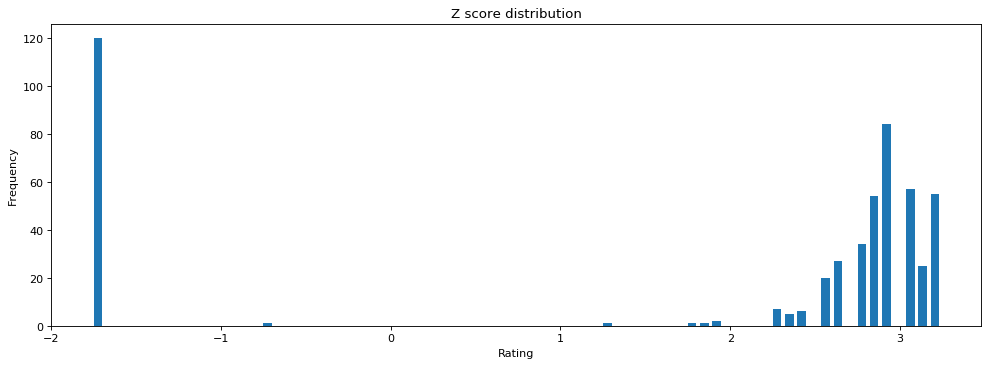

In [19]:
# z-score of rating
df_z_score_rating = sqlContext.sql("SELECT (Rating - " + \
                                   str(mean_rating) + " / " + str(std_rating) + \
                                   ") as Rating FROM df_ratio")               

print "\nZ-score of rating:"
df_z_score_rating.show(5)

bins, hist = df_z_score_rating.select("Rating").rdd.flatMap(lambda x: x).histogram(70)
hist = np.asarray(hist)
bins = np.asarray(bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# plotting
fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(center, hist, align='center', width=width)
plt.title("Z score distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Xác suất
- Xác suất (probability)
$$probability = \frac{event(s)}{outcome(s)}$$

- Phép đếm hoán vị (permutation)
$$P(n, r) = \frac{n!}{(n - r)!}\\$$
$$n: distinct\ object\ to\ choose\ from$$
$$r: spaces\ to\ fill.$$

- Phép đếm tổ hợp (combination)
$$C(n, r) = \frac{n!}{r!(n - r)!}$$

- Xác suất có điều kiện (conditional probability)
$$P(B|A) = \frac{P(A \cap B)}{P(A)}$$

- Biến độc lập và biến phụ thuộc (independent/dependent variable)
    - Independent variable: 
        * Dress_ID
        * Style
        * Price
        * Rating
        * Size
        * Season
        * NeckLine
        * SleeveLength
        * waiseline
        * Material
        * FabricType
        * Decoration
        * Pattern Type
    - Dependent variable: Recommendation

- Bayes
$$P(A|B) = \frac{P(B|A) P(A)}{P(B)}\\$$
$$Posterior = \frac{Likelihood * Prior}{Evidence}$$

In [20]:
# Conditional probability
# P(Style:sexy|Season:summer) = P(Style:sexy and Season:summer) / P(Season:summer)
num_items = df.select("Rating").count()
df_summer = df.select("Season").where(df["Season"] == "Summer")
p_summer = df_summer.count() * 100.0 / num_items

df_sexy_summer = df.select(df.Style, df.Season).where("Style = 'Sexy' and Season = 'Summer'")
p_sexy_summer = df_sexy_summer.count() * 100.0 / num_items

p_sexy_given_summer = p_sexy_summer * 100 / p_summer

print "P(Season:summer)", p_summer
print "P(Style:sexy and Season:summer)", p_sexy_summer
print "P(Style:sexy|Season:summer)", p_sexy_given_summer

P(Season:summer) 31.8
P(Style:sexy and Season:summer) 4.8
P(Style:sexy|Season:summer) 15.0943396226


In [21]:
# Bayes
# P(Style:sexy|Season:summer) = P(Season:summer|Style:sexy) * P(Style:sexy) / P(Season:summer)
num_items = df.select("Rating").count()
df_style = df.select(df.Style).where("Style = 'Sexy'")
p_sexy = df_style.count() * 100.0 / num_items

p_summer_given_sexy = p_sexy_summer * 100 / p_sexy

p_sexy_given_summer_bayes = p_summer_given_sexy * p_sexy / p_summer

print "P(Style:sexy)", p_sexy
print "P(Season:summer)", p_summer
print "P(Season:summer|Style:sexy)", p_summer_given_sexy
print "P(Style:sexy|Season:summer) Bayes:", p_sexy_given_summer_bayes

P(Style:sexy) 13.8
P(Season:summer) 31.8
P(Season:summer|Style:sexy) 34.7826086957
P(Style:sexy|Season:summer) Bayes: 15.0943396226


# Central limit theorem
- Dịch thành: Định lý giới hạn trung tâm.
- Cho quần thể có phân bố bất kỳ.
- Ta thực hiện lấy mẫu nhiều lần trên quần thể cho trước với số lượng xác định.
- Mỗi lần lấy mẫu ta đi tính trung bình mẫu
- Tổng hợp các trung bình mẫu này lại thành histogram.
- Quan sát phân phối của trung bình mẫu của các mẫu ngẫu nhiên, ta thấy đây gần giống với phân phối chuẩn dù cho quần thể ban đầu có phân bố bất kỳ.

In [25]:
# Simulating Central limit theorem
num_sample = 30.0
num_loop = 1000
num_items = df.select("Rating").count()
samp_mean_ls = []

for i in range(0, num_loop):
    df_rating_sample = df.select("Rating").sample(False, num_sample / num_items)
    sum_of_sample = df_rating_sample.agg(F.sum(df_rating_sample.Rating)).first()[0]

    x_bar = sum_of_sample * 100 / num_sample
    samp_mean_ls.append(x_bar)    

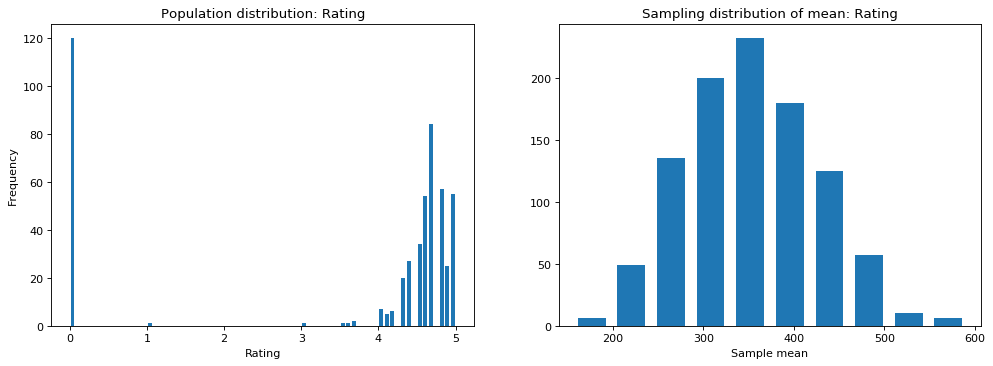

In [26]:
# ploting population
fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
bins, hist = df_ratio.select("Rating").rdd.flatMap(lambda x: x).histogram(70)
hist = np.asarray(hist)
bins = np.asarray(bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)
plt.title("Population distribution: Rating")
plt.xlabel("Rating")
plt.ylabel("Frequency")

# ploting sampling
plt.subplot(1, 2, 2)
hist, bins = np.histogram(samp_mean_ls)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("Sampling distribution of mean: Rating")
plt.xlabel("Sample mean")
plt.show()